# Plot the learned Sensor Embedding

In [40]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from network.models.architectures.CIL_multiview.CIL_multiview_vit_oneseq import CIL_multiview_vit_oneseq
import os
import json
from configs import g_conf, set_type_of_process, merge_with_yaml

exp_batch = 'CIL_ViT_oneseq'
exp_name = 'CILv2_3cam_vitb32_Town01Full_oneseq_bs256_fPE_wmupcdown_lr1e4_noACT_noCLS_outBaseline1PatchMLP_hres_sensorEmb'

merge_with_yaml(os.path.join('configs', exp_batch, f'{exp_name}.yaml'))
g_conf.PROCESS_NAME = 'train_val'
g_conf.DATASET_PATH = '/datatmp/Datasets/yixiao/CARLA'

os.environ['DATASET_PATH'] = g_conf.DATASET_PATH

model = CIL_multiview_vit_oneseq(g_conf.MODEL_CONFIGURATION)

Using a sensor embedding...


Note that this model/checkpoint doesn't have any extra tokens, so it's the equivalent to Yi's:

In [7]:
sensor_emb = model.sensor_embedding
print(sensor_emb.shape)  # [1, 243, 768] == [1, 3x(9*9), 768]

torch.Size([1, 243, 768])


As in the ViT paper, let's plot the cosine similarity between each of these embeddings:

In [58]:
import torch
import torch.nn.functional as F
import numpy as np
from einops import rearrange

@torch.no_grad()
def patch_cos_sim(sensor_embedding: torch.Tensor, idx_i: int, idx_j: int, rows: int = 9, cols: int = 27):
    """ Return a MxN matrix of cosine similarity between patch at (idx_i, idx_j) and the rest of the patches """
    sensor_embedding = rearrange(sensor_embedding, '1 (h w) d -> h w d', h=rows, w=cols)
    sensor_embedding = sensor_embedding.cpu()
    nrows, ncols, _ = sensor_embedding.shape
    cossim_patches = []
    for i in range(nrows):
        for j in range(ncols):
            cossim_patches.append(F.cosine_similarity(sensor_embedding[idx_i, idx_j], sensor_embedding[i, j], dim=0))

    return np.array(cossim_patches).reshape(nrows, ncols)

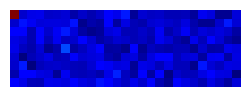

In [59]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3, 1))
ax.set_axis_off()
ax.imshow(patch_cos_sim(sensor_emb, 0, 0), cmap='jet', interpolation='nearest')

## Load the checkpoint

In [41]:
from _utils.training_utils import check_saved_checkpoints

latest_checkpoint = check_saved_checkpoints(
    os.path.join('/run/user/1001/gvfs/sftp:host=158.109.8.151,port=22345/datafast/experiments/dporres/VisionTFM/',
                 '_results', g_conf.EXPERIMENT_BATCH_NAME, g_conf.EXPERIMENT_NAME, 'checkpoints'))

checkpoint = torch.load(latest_checkpoint)

In [42]:
trained_sensor_emb = checkpoint['model']['_model.sensor_embedding']

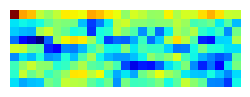

In [65]:
fig, ax = plt.subplots(figsize=(3, 1))
ax.set_axis_off()
ax.imshow(patch_cos_sim(trained_sensor_emb, 0, 0), cmap='jet', interpolation='nearest')

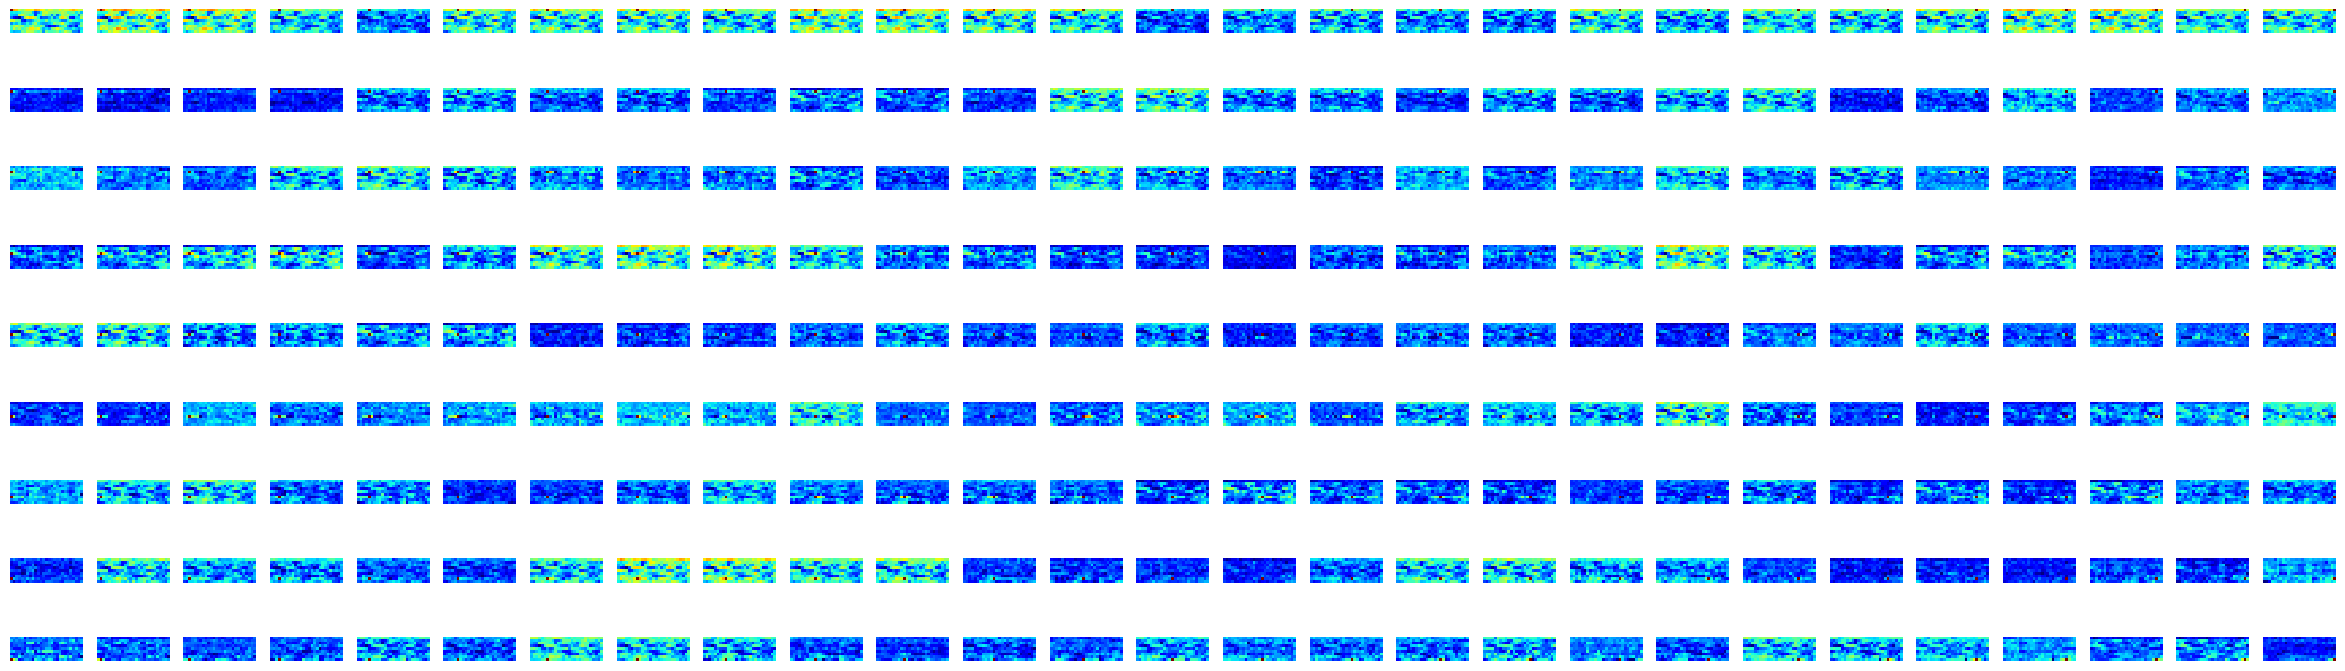

In [72]:
# For each patch, plot the cosine similarity with the rest of the patches
# Plot all of this in a grid, with no axis
ncols = 27
nrows = 9

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 9))
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].set_axis_off()
        axes[i, j].imshow(patch_cos_sim(trained_sensor_emb, i, j), cmap='jet', interpolation='nearest')

plt.show()

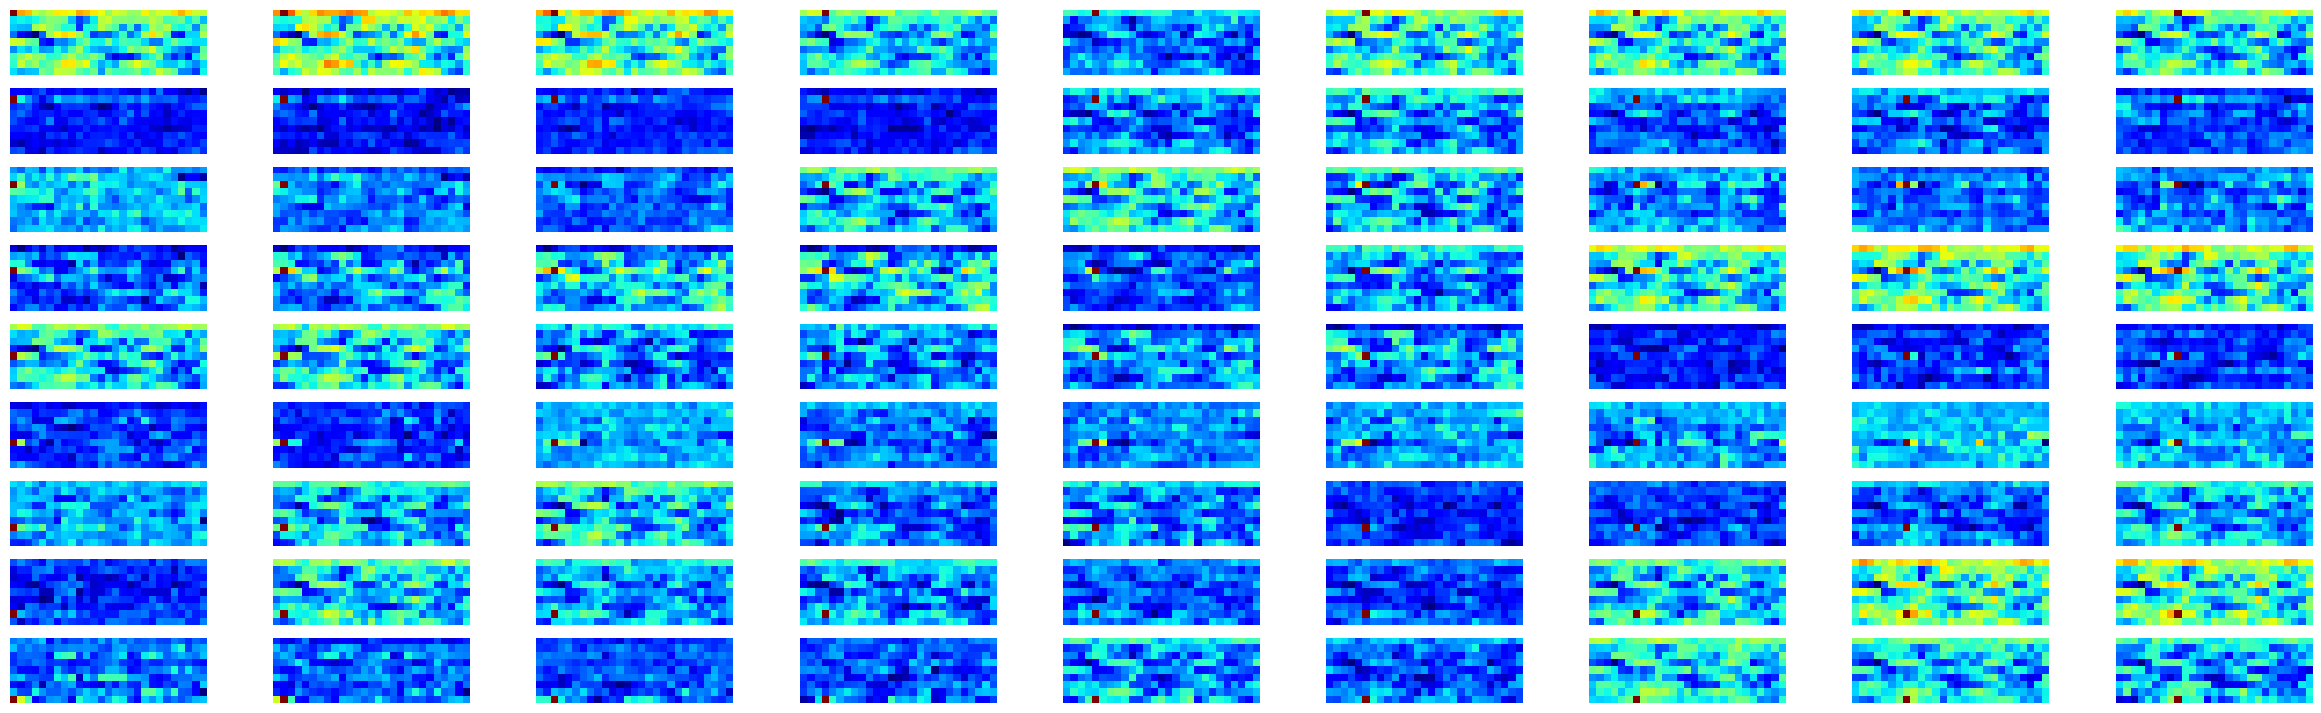

In [81]:
# Do the same as before, but just the first 9 columns
ncols = 9
nrows = 9

avg_left_cossim = np.zeros((nrows, 3*ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 9))
for i in range(nrows):
    for j in range(ncols):
        csim = patch_cos_sim(trained_sensor_emb, i, j)
        axes[i, j].set_axis_off()
        axes[i, j].imshow(csim, cmap='jet', interpolation='nearest')
        avg_left_cossim += csim / (9*9)

plt.show()

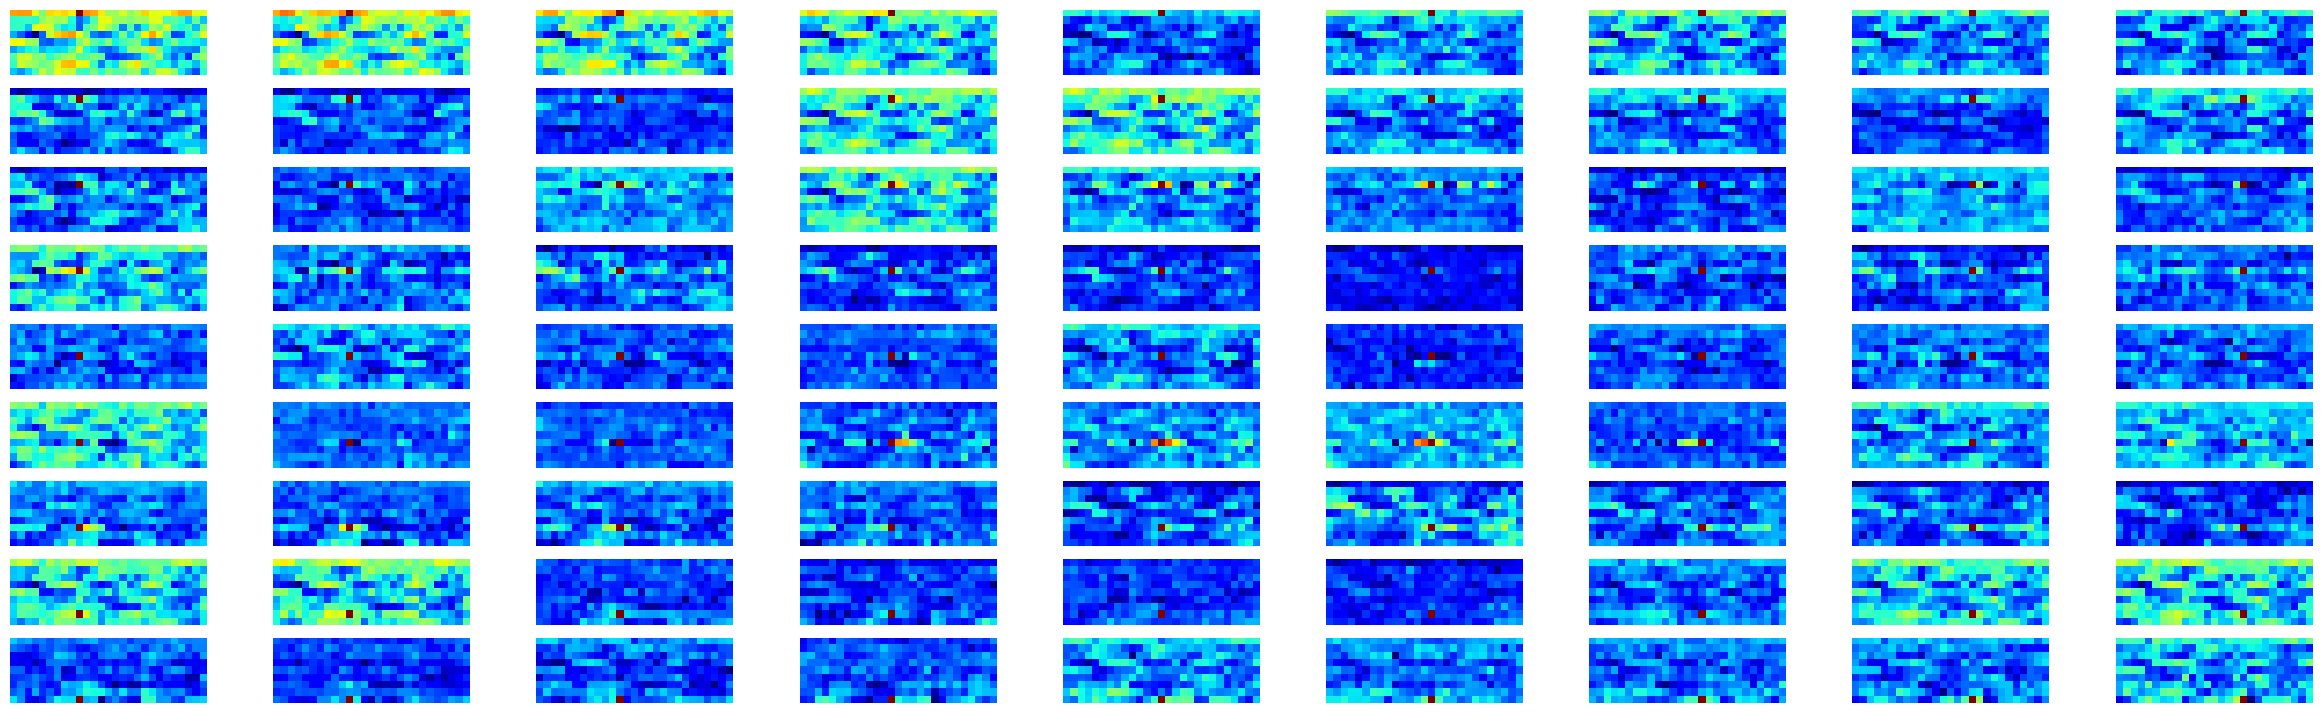

In [83]:
# Do the same as before, but just the middle 9 columns
ncols = 9
nrows = 9

avg_center_cossim = np.zeros((nrows, 3*ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 9))
for i in range(nrows):
    for j in range(9, 9 + ncols):
        csim = patch_cos_sim(trained_sensor_emb, i, j)
        avg_center_cossim += csim / (9*9)
        axes[i, j - 9].set_axis_off()
        axes[i, j - 9].imshow(csim, cmap='jet', interpolation='nearest')

plt.show()

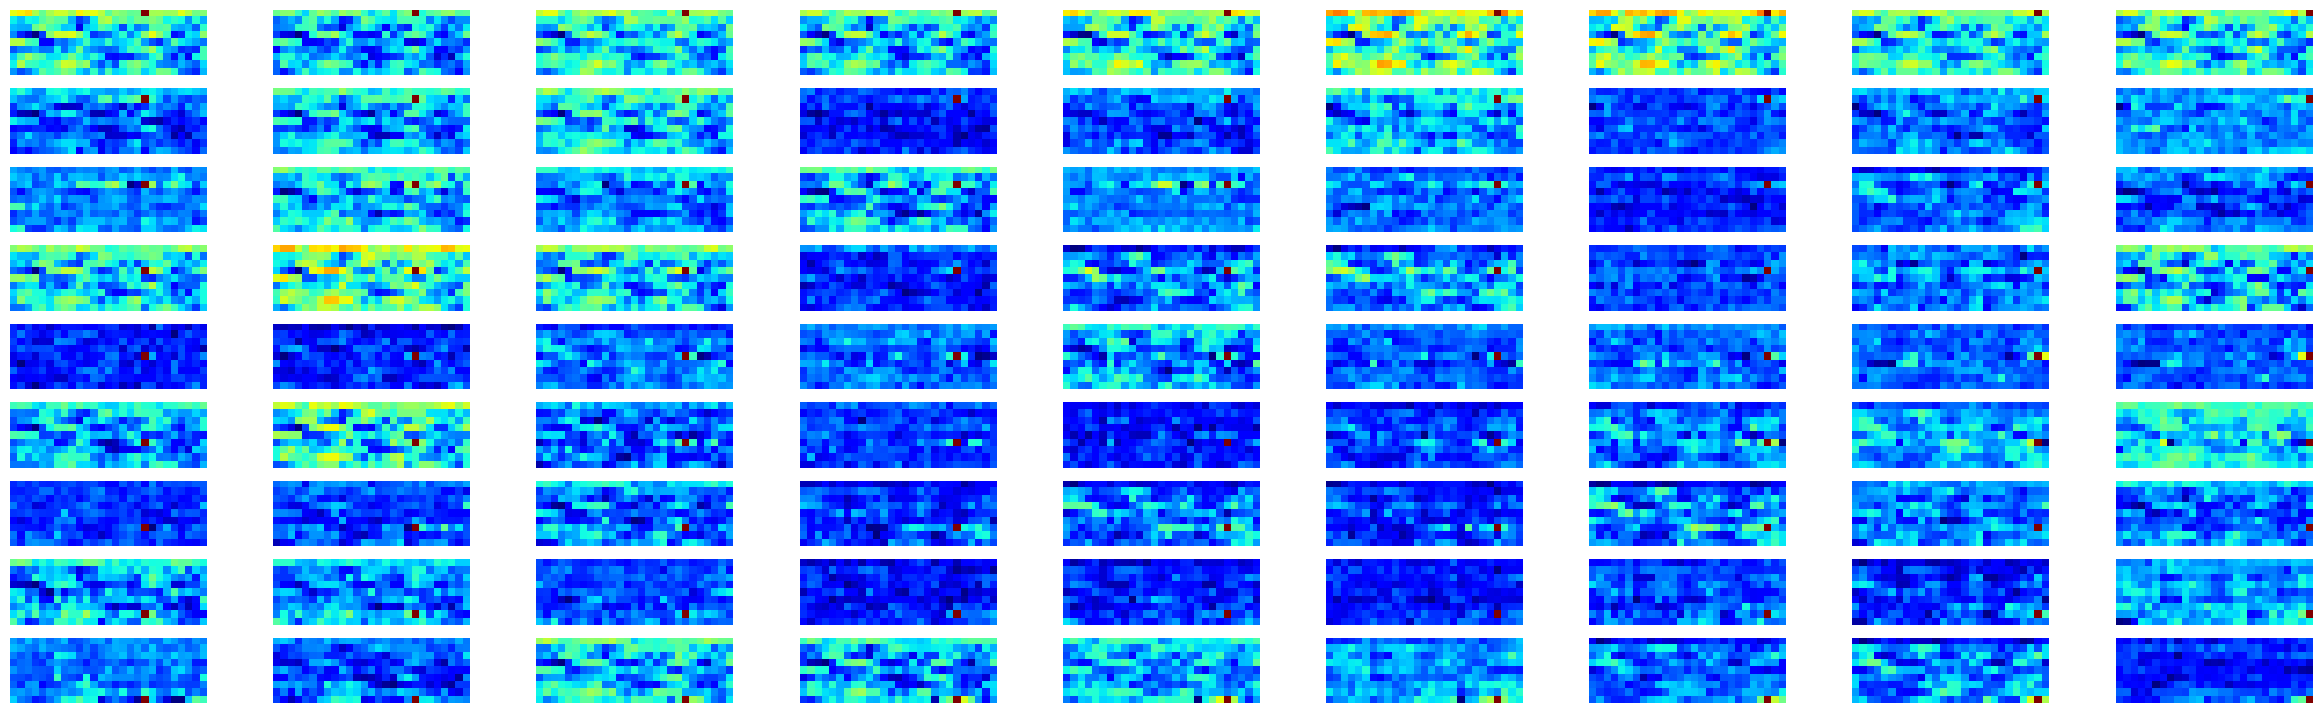

In [84]:
# Do the same as before, but just the middle 9 columns
ncols = 9
nrows = 9

avg_right_cossim = np.zeros((nrows, 3*ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 9))
for i in range(nrows):
    for j in range(9, 18 + ncols):
        csim = patch_cos_sim(trained_sensor_emb, i, j)
        avg_right_cossim += csim / (9*9)
        axes[i, j - 18].set_axis_off()
        axes[i, j - 18].imshow(csim, cmap='jet', interpolation='nearest')

plt.show()

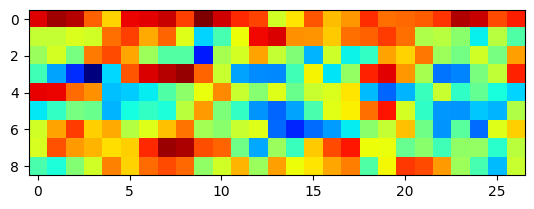

In [86]:
plt.imshow(avg_left_cossim, cmap='jet', interpolation='nearest')
plt.show()

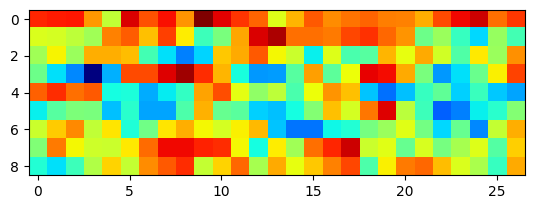

In [87]:
plt.imshow(avg_center_cossim, cmap='jet', interpolation='nearest')
plt.show()

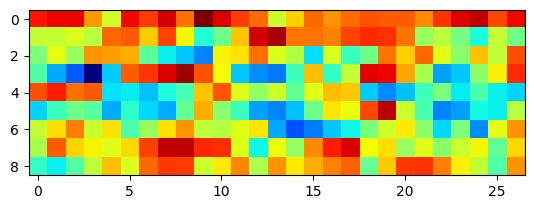

In [88]:
plt.imshow(avg_right_cossim, cmap='jet', interpolation='nearest')
plt.show()

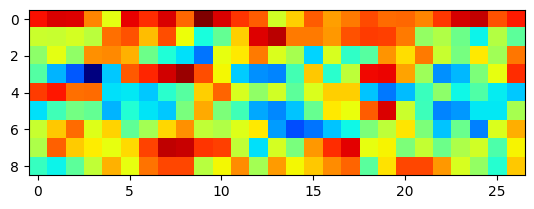

In [89]:
avg_cossim = avg_left_cossim + avg_center_cossim + avg_right_cossim
avg_cossim /= 3
plt.imshow(avg_cossim, cmap='jet', interpolation='nearest')
plt.show()